In [71]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development.

In [73]:
from google.colab import files

# Abre un cuadro de diálogo para subir archivos desde tu PC
uploaded = files.upload()


Saving kg_train.csv to kg_train (1).csv


In [74]:
from google.colab import files

# Abre un cuadro de diálogo para subir archivos desde tu PC
uploaded = files.upload()


Saving kg_test.csv to kg_test (1).csv


In [75]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("/content/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development.
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


In [76]:
data_test = pd.read_csv("/content/kg_test.csv",encoding='latin-1')

In [77]:
data_test.head()

,text
0,usiness is for the fact that the deceased man ...
1,They are happy to adjust to the afternoon. I a...
2,Lael Brainard was confirmed 78-19 this afterno...
3,H <hrod17@clintonemail.com>Friday March 26 201...
4,"n;""> Dear Good Friend,<br><br><br>I am happy t..."


In [78]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5964 entries, 0 to 5963
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5964 non-null   object
dtypes: object(1)
memory usage: 46.7+ KB


In [79]:
data_test.values_counts("label")

AttributeError: 'DataFrame' object has no attribute 'values_counts'

 ANALYSING THE DATASET

In [80]:
data

,text,label
0,"DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...",1
1,Will do.,0
2,Nora--Cheryl has emailed dozens of memos about...,0
3,Dear Sir=2FMadam=2C I know that this proposal ...,1
4,fyi,0
...,...,...
995,So what's the latest? It sounds contradictory ...,0
996,"TRANSFER OF 36,759,000.00 MILLION POUNDS TO YO...",1
997,Barb I will call to explain. Are you back in t...,0
998,Yang on travelNot free tonite.May work tomorrow,0


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [82]:
data.describe()

,label
count,1000.000000
mean,0.442000
std,0.496873
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [83]:
data.value_counts("label")

,count
label,
0,558
1,442


In [84]:
print(data.head())

                                                text  label
0  DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...      1
1                                           Will do.      0
2  Nora--Cheryl has emailed dozens of memos about...      0
3  Dear Sir=2FMadam=2C I know that this proposal ...      1
4                                                fyi      0


In [85]:
# Filter only spam messages
spam_emails = data[data['label'] == 1]
print("\n📩 SPAM EXAMPLES:")
print(spam_emails['text'].head())

# Filter only non-spam messages
ham_emails = data[data['label'] == 0]
print("\n✅ NON-SPAM EXAMPLES:")
print(ham_emails['text'].head())


📩 SPAM EXAMPLES:
0     DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...
3     Dear Sir=2FMadam=2C I know that this proposal ...
6     Dear Sir,I am Engr. Ugo Nzego with the Enginee...
9     <P>1 25% for you as the account owner <BR>2 65...
10    STRONG><A href=3D"http://www.cnn.com/2003/WORL...
Name: text, dtype: object

✅ NON-SPAM EXAMPLES:
1                                             Will do.
2    Nora--Cheryl has emailed dozens of memos about...
4                                                  fyi
5    sure -- bottom line - you need a special secur...
7    Abedin Huma <AbedinH@state.gov>Saturday Novemb...
Name: text, dtype: object


### Let's divide the training and test set into two partitions

In [86]:
# Your code
from sklearn.model_selection import train_test_split

# the target column is called 'label'

X = data.drop('label', axis=1)  # Features (independent variables)
y = data['label']               # Target (dependent variable)

# Split the dataset: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display sizes of each partition
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (800, 1)
Test set size: (200, 1)


## Data Preprocessing

In [87]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [88]:
# Your code

import re

def clean_html(text):
    """
    Cleans HTML text by removing:
    1. Inline JavaScript and CSS
    2. HTML comments
    3. All remaining HTML tags
    """
    # Remove inline JavaScript/CSS code
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)

    # Remove HTML comments (must come before removing tags)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

    # Remove all remaining HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove extra whitespace and line breaks
    text = re.sub(r'\s+', ' ', text).strip()

    return text


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters

- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [89]:
# Your code

import re

def normalize_text(text):
    """
    Performs general text normalization:
    - Removes special characters and punctuation
    - Removes numbers
    - Removes single characters
    - Removes single characters from start
    - Replaces multiple spaces with a single space
    - Removes prefixed 'b' (from byte strings)
    - Converts text to lowercase
    """
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove single characters from start
    text = re.sub(r'^[a-zA-Z]\s+', '', text)

    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Remove prefixed 'b' (from byte strings like b'text')
    text = re.sub(r'^b\s+', '', text)

    # Convert to lowercase
    text = text.lower()

    return text.strip()


## Now let's work on removing stopwords
Remove the stopwords.

In [90]:
# Your code

# Function to remove stopwords

def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))

    filtered_tokens = []

    for word in tokens:
        if word.isalpha() and word not in stop_words:
            filtered_tokens.append(word)

    return " ".join(filtered_tokens)





## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [91]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required data (run once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [92]:
# Your code

def lemmatize_text(text):
    """
    Breaks text into words and reduces each word to its base form.
    Example: 'running dogs' → 'run dog'
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_words = []
    for word in tokens:
        lemmatized_words.append(lemmatizer.lemmatize(word))

    # LIST COMPREHENSION lemmatized_words = [lemmatizer.lemmatize(word)) for word in tokens]

    return " ".join(lemmatized_words)


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [94]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Download necessary NLTK data (stopwords, punkt, punkt_tab)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Added punkt_tab download

# Function to clean HTML
def clean_html(text):
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to normalize text (from K9mV7HHbZK8L)
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'^[a-zA-Z]\s+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    return text.strip()

# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered_tokens)

# Function to stem text using SnowballStemmer (from 3dc-oCHlk6jT)
def stem_text(text):
    snowball = SnowballStemmer('english')
    tokens = word_tokenize(text)
    stemmed_words = [snowball.stem(word) for word in tokens]
    return " ".join(stemmed_words)


# Apply cleaning and preprocessing steps

data['clean_text'] = data['text'].apply(clean_html)
data['clean_text'] = data['clean_text'].apply(normalize_text)
data['clean_text'] = data['clean_text'].apply(remove_stopwords)
data['clean_text'] = data['clean_text'].apply(stem_text) # Added stemming




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Create Bag of Words representation
vectorizer = CountVectorizer(max_features=5000)  # limit vocabulary for performance


# Check if 'clean_text' column exists before fitting
if 'clean_text' in data.columns:
    X_bow = vectorizer.fit_transform(data['clean_text'])

    # Convert to DataFrame
    bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

    # Separate HAM and SPAM messages
    # ⚠️ Adjust depending on your label values
    # Ensure 'label' column exists


    if 'label' in data.columns:
        # Assuming 0 is HAM and 1 is SPAM based on previous code logic
        ham_df = bow_df[data['label'] == 0]   # Non-spam
        spam_df = bow_df[data['label'] == 1]  # Spam

    # Calculate total word counts
        ham_words = ham_df.sum().sort_values(ascending=False).head(10)
        spam_words = spam_df.sum().sort_values(ascending=False).head(10)

     # Display results
        print("📩 Top 10 words in HAM messages:\n")
        print(ham_words)

        print("\n🚨 Top 10 words in SPAM messages:\n")
        print(spam_words)

     # Optional: Visualize the top words
        plt.figure(figsize=(10,4))
        ham_words.plot(kind='bar', color='skyblue', title='Top 10 Words in HAM Messages')
        plt.show()

        plt.figure(figsize=(10,4))
        spam_words.plot(kind='bar', color='salmon', title='Top 10 Words in SPAM Messages')
        plt.show()
    else:
        print("Error: 'label' column not found in the DataFrame.")
else:
    print("Error: 'clean_text' column not found after preprocessing.")

## Extra features

In [95]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).

# Define cleaning functions again (or ensure they are defined in a previous executed cell)
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Assuming necessary NLTK data (stopwords, punkt) has been downloaded in a previous cell

# Function to clean HTML
def clean_html(text):
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to normalize text (from K9mV7HHbZK8L)
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'^[a-zA-Z]\s+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    return text.strip()

# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered_tokens)

# Function to stem text using SnowballStemmer (from 3dc-oCHlk6jT)
def stem_text(text):
    snowball = SnowballStemmer('english')
    tokens = word_tokenize(text)
    stemmed_words = [snowball.stem(word) for word in tokens]
    return " ".join(stemmed_words)

# Apply cleaning and preprocessing steps to X_train and X_test
X_train['preprocessed_text'] = X_train['text'].apply(clean_html).apply(normalize_text).apply(remove_stopwords).apply(stem_text)
X_test['preprocessed_text'] = X_test['text'].apply(clean_html).apply(normalize_text).apply(remove_stopwords).apply(stem_text)




In [103]:
money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

X_train['money_mark'] = X_train['preprocessed_text'].str.contains(money_simbol_list)*1
X_train['suspicious_words'] = X_train['preprocessed_text'].str.contains(suspicious_words)*1
X_train['text_len'] = X_train['preprocessed_text'].apply(lambda x: len(x))

X_test['money_mark'] = X_test['preprocessed_text'].str.contains(money_simbol_list)*1
X_test['suspicious_words'] = X_test['preprocessed_text'].str.contains(suspicious_words)*1
X_test['text_len'] = X_test['preprocessed_text'].apply(lambda x: len(x))

print("X_train with extra features:")
display(X_train.head())
print("\nX_test with extra features:")
display(X_test.head())

X_train with extra features:


,text,preprocessed_text,money_mark,suspicious_words,text_len
442,Dear=2C Good day hope fine=2Cdear am writting ...,dear good day hope fine cdear writ mail due re...,1,1,905
962,FROM MR HENRY KABORETHE CHIEF AUDITOR INCHARGE...,mr henri kaboreth chief auditor inchargeforeig...,0,1,1710
971,Will do.,,0,0,0
190,FROM THE DESK OF DR.ADAMU ISMALERAUDITING AND...,desk dr adamu ismaleraudit account manag bank ...,1,1,347
551,"Dear Friend, My name is LOI C.ESTRADA,The wife...",dear friend name loi estrada wife mr josephest...,1,1,1304



X_test with extra features:


,text,preprocessed_text,money_mark,suspicious_words,text_len
222,STRICTLY PERSONALPermit me to introduce myself...,strict personalpermit introduc mr joyc zuma ba...,0,1,515
824,Dear Nancy--I very much want to meet and we've...,dear nanci much want meet tri pin schedul enou...,0,0,200
505,REQUEST FOR BUSINESS PARTNERSHIPI am PATRICK A...,request busi partnershipi patrick atik directo...,1,1,1792
165,Soneri Bank LimitedSilver Jubilee Center=2CBri...,soneri bank limitedsilv jubile center cbritto ...,1,1,1650
832,"Dear Partner,I am a Fund Manager with Fidelity...",dear partner fund manag fidel invest uk handl ...,0,1,588


## How would work the Bag of Words with Count Vectorizer concept?

In [ ]:
# Your code
from sklearn.feature_extraction.text import CountVectorizer

texts = ["Free money now", "Win money win prizes", "Free prizes now"]

# Create the vectorizer
vectorizer = CountVectorizer()

# Fit and transform your text data
X_bow = vectorizer.fit_transform(texts)

# See the vocabulary
print(vectorizer.get_feature_names_out())

# Convert to array
print(X_bow.toarray())


## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

# LOAD the vectorizer
# You can limit max_features to speed up (e.g., 5000)
vectorizer = TfidfVectorizer(max_features=5000)

# FIT the vectorizer to the entire dataset and transform the text
X_tfidf = vectorizer.fit_transform(data['clean_text'])

# Print the shape of the resulting matrix
print("TF-IDF matrix shape:", X_tfidf.shape)


## And the Train a Classifier?

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split the TF-IDF data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    data['label'],       # Target column (0 = ham, 1 = spam)
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Initialize and train the Logistic Regression model

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions

y_pred = model.predict(X_test)

# Evaluate the model

accuracy = accuracy_score(y_test, y_pred)
print("\n✅ Accuracy:", round(accuracy, 4))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix visualization

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to **find the most relevant features**.

For example, you can test the following options and check which of them performs better:
- Using "Bag of Words" only
- Using "TF-IDF" only
- Bag of Words + extra flags (money_mark, suspicious_words, text_len)
- TF-IDF + extra flags


You can work with teams of two persons (recommended).

#  **Using "Bag of Words"**

BoW shape: (800, 5000)

✅ Accuracy (BoW): 0.98

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       112
           1       0.96      1.00      0.98        88

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



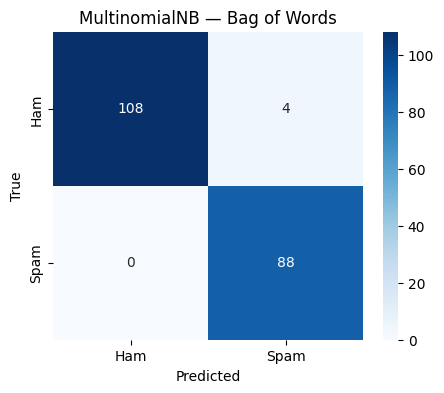

In [96]:
# Your code
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Vectorize using Bag of Words
vectorizer_bow = CountVectorizer(max_features=5000)

# Use the 'preprocessed_text' column for vectorization and convert to list
X_train_bow = vectorizer_bow.fit_transform(X_train['preprocessed_text'].tolist())
X_test_bow = vectorizer_bow.transform(X_test['preprocessed_text'].tolist())


print("BoW shape:", X_train_bow.shape)

# Train MultinomialNB (default)
model_bow = MultinomialNB()
model_bow.fit(X_train_bow, y_train)

# Predict and evaluate
y_pred_bow = model_bow.predict(X_test_bow)

print("\n✅ Accuracy (BoW):", round(accuracy_score(y_test, y_pred_bow), 4))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_bow))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bow)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MultinomialNB — Bag of Words')
plt.show()

#  **Using "TF-IDF"**

TF-IDF matrix shape: (800, 5000)

✅ Accuracy: 0.98

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       112
           1       0.96      1.00      0.98        88

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



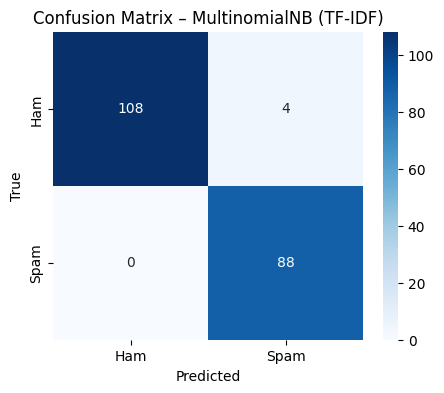


🚨 Top 20 Spam words:
['bank' 'money' 'account' 'fund' 'transact' 'transfer' 'nbsp' 'kin'
 'deposit' 'million' 'invest' 'dollar' 'contact' 'compani' 'father' 'sum'
 'claim' 'busi' 'foreign' 'husband']

📩 Top 20 Ham words:
['fyi' 'yes' 'ok' 'tomorrow' 'pm' 'cheryl' 'talk' 'pls' 'print' 'gov'
 'thx' 'huma' 'blackberri' 'wednesday' 'jake' 'sheet' 'monday' 'lona'
 'schedul' 'today']


In [102]:
# Vectorize using TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

vectorizer_tfidf = TfidfVectorizer(max_features=5000)

# Use the 'preprocessed_text' column for vectorization and convert to list
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train['preprocessed_text'])
X_test_tfidf  = vectorizer_tfidf.transform(X_test['preprocessed_text'])

print("TF-IDF matrix shape:", X_train_tfidf.shape)


# Train the MultinomialNB classifier (default parameters)

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)


# Evaluate the model

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("\n✅ Accuracy:", round(accuracy_score(y_test, y_pred_tfidf), 4))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_tfidf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – MultinomialNB (TF-IDF)')
plt.show()

# Most relevant features (top words)


feature_names = vectorizer_tfidf.get_feature_names_out()
log_prob = model_tfidf.feature_log_prob_

spam_influence = log_prob[1] - log_prob[0]
top_spam_idx = np.argsort(spam_influence)[-20:][::-1]
top_ham_idx  = np.argsort(spam_influence)[:20]

print("\n🚨 Top 20 Spam words:")
print(feature_names[top_spam_idx])

print("\n📩 Top 20 Ham words:")
print(feature_names[top_ham_idx])

#**Using Bag of Words + extra flags (money_mark, suspicious_words, text_len)**



In [104]:

# Create extra features

import re

money_simbol_list = "|".join(["euro", "dollar", "pound", "€", r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund",
                             "transfer","transaction","win","deposit","password"])

# Create new binary/numeric features
X_train = X_train.copy()
X_test = X_test.copy()

X_train['money_mark'] = X_train['preprocessed_text'].str.contains(money_simbol_list, flags=re.IGNORECASE, regex=True) * 1
X_train['suspicious_words'] = X_train['preprocessed_text'].str.contains(suspicious_words, flags=re.IGNORECASE, regex=True) * 1
X_train['text_len'] = X_train['preprocessed_text'].apply(len)

X_test['money_mark'] = X_test['preprocessed_text'].str.contains(money_simbol_list, flags=re.IGNORECASE, regex=True) * 1
X_test['suspicious_words'] = X_test['preprocessed_text'].str.contains(suspicious_words, flags=re.IGNORECASE, regex=True) * 1
X_test['text_len'] = X_test['preprocessed_text'].apply(len)

print("✅ Extra features created!")
display(X_train.head())


✅ Extra features created!


,text,preprocessed_text,money_mark,suspicious_words,text_len
442,Dear=2C Good day hope fine=2Cdear am writting ...,dear good day hope fine cdear writ mail due re...,1,1,905
962,FROM MR HENRY KABORETHE CHIEF AUDITOR INCHARGE...,mr henri kaboreth chief auditor inchargeforeig...,0,1,1710
971,Will do.,,0,0,0
190,FROM THE DESK OF DR.ADAMU ISMALERAUDITING AND...,desk dr adamu ismaleraudit account manag bank ...,1,1,347
551,"Dear Friend, My name is LOI C.ESTRADA,The wife...",dear friend name loi estrada wife mr josephest...,1,1,1304


In [105]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, classification_report

# Vectorize text (BoW)
vectorizer_bow = CountVectorizer(max_features=5000)
X_train_bow = vectorizer_bow.fit_transform(X_train['preprocessed_text'].tolist())
X_test_bow  = vectorizer_bow.transform(X_test['preprocessed_text'].tolist())

# Combine BoW matrix with numeric columns
extra_train = X_train[['money_mark','suspicious_words','text_len']].values
extra_test  = X_test[['money_mark','suspicious_words','text_len']].values

# hstack = horizontal stacking (combine text + numeric features)
from scipy.sparse import hstack
X_train_bow_extra = hstack([X_train_bow, extra_train])
X_test_bow_extra  = hstack([X_test_bow, extra_test])

# Train MultinomialNB (default parameters)
model_bow_extra = MultinomialNB()
model_bow_extra.fit(X_train_bow_extra, y_train)

# Evaluate
y_pred_bow_extra = model_bow_extra.predict(X_test_bow_extra)
print("\n📊 BoW + Extra Flags Accuracy:", round(accuracy_score(y_test, y_pred_bow_extra),4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bow_extra))



📊 BoW + Extra Flags Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       112
           1       0.94      1.00      0.97        88

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



# **Using Bag of Words + extra flags (money_mark, suspicious_words, text_len)**

In [106]:
#  Create extra features

import re

money_simbol_list = "|".join(["euro", "dollar", "pound", "€", r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund",
                             "transfer","transaction","win","deposit","password"])

# Create new binary/numeric features
X_train = X_train.copy()
X_test = X_test.copy()

X_train['money_mark'] = X_train['preprocessed_text'].str.contains(money_simbol_list, flags=re.IGNORECASE, regex=True) * 1
X_train['suspicious_words'] = X_train['preprocessed_text'].str.contains(suspicious_words, flags=re.IGNORECASE, regex=True) * 1
X_train['text_len'] = X_train['preprocessed_text'].apply(len)

X_test['money_mark'] = X_test['preprocessed_text'].str.contains(money_simbol_list, flags=re.IGNORECASE, regex=True) * 1
X_test['suspicious_words'] = X_test['preprocessed_text'].str.contains(suspicious_words, flags=re.IGNORECASE, regex=True) * 1
X_test['text_len'] = X_test['preprocessed_text'].apply(len)

print("✅ Extra features created!")
display(X_train.head())

✅ Extra features created!


,text,preprocessed_text,money_mark,suspicious_words,text_len
442,Dear=2C Good day hope fine=2Cdear am writting ...,dear good day hope fine cdear writ mail due re...,1,1,905
962,FROM MR HENRY KABORETHE CHIEF AUDITOR INCHARGE...,mr henri kaboreth chief auditor inchargeforeig...,0,1,1710
971,Will do.,,0,0,0
190,FROM THE DESK OF DR.ADAMU ISMALERAUDITING AND...,desk dr adamu ismaleraudit account manag bank ...,1,1,347
551,"Dear Friend, My name is LOI C.ESTRADA,The wife...",dear friend name loi estrada wife mr josephest...,1,1,1304


In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text (TF-IDF)
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train['preprocessed_text'].tolist())
X_test_tfidf  = vectorizer_tfidf.transform(X_test['preprocessed_text'].tolist())

# Combine TF-IDF matrix with numeric columns
X_train_tfidf_extra = hstack([X_train_tfidf, extra_train])
X_test_tfidf_extra  = hstack([X_test_tfidf, extra_test])

# Train MultinomialNB
model_tfidf_extra = MultinomialNB()
model_tfidf_extra.fit(X_train_tfidf_extra, y_train)

# Evaluate
y_pred_tfidf_extra = model_tfidf_extra.predict(X_test_tfidf_extra)
print("\n📊 TF-IDF + Extra Flags Accuracy:", round(accuracy_score(y_test, y_pred_tfidf_extra),4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tfidf_extra))



📊 TF-IDF + Extra Flags Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91       112
           1       0.84      0.99      0.91        88

    accuracy                           0.91       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.92      0.91      0.91       200

